# HW1 : Regression, Cross-Validation, and  Regularization

In [37]:
import os
import numpy as np
import warnings

import sklearn.preprocessing
import sklearn.pipeline
import sklearn.linear_model
import sklearn.neighbors
import sklearn.model_selection

from performance_metrics import calc_mean_squared_error


In [38]:
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set('notebook', font_scale=1.25, style='whitegrid')

# Set random seed to make all computations reproducible

In [39]:
SEED = 12345

# Load the dataset

Predefined 'x' and 'y' arrays for train/valid/test

In [40]:
DATA_DIR = 'data_auto/'

In [41]:
x_tr_MF = np.loadtxt(os.path.join(DATA_DIR, 'x_train.csv'), delimiter=',', skiprows=1)
x_va_NF = np.loadtxt(os.path.join(DATA_DIR, 'x_valid.csv'), delimiter=',', skiprows=1)
x_te_PF = np.loadtxt(os.path.join(DATA_DIR, 'x_test.csv'), delimiter=',', skiprows=1)

In [42]:
y_tr_M = np.loadtxt(os.path.join(DATA_DIR, 'y_train.csv'), delimiter=',', skiprows=1)
y_va_N = np.loadtxt(os.path.join(DATA_DIR, 'y_valid.csv'), delimiter=',', skiprows=1)
y_te_P = np.loadtxt(os.path.join(DATA_DIR, 'y_test.csv'), delimiter=',', skiprows=1)

# Load completed code

In [43]:
from cross_validation import train_models_and_calc_scores_for_n_fold_cv
from performance_metrics import calc_mean_squared_error

# Define useful plotting functions

In [44]:
def plot_train_and_valid_error_vs_degree(
        degree_list, err_tr_list=None, err_va_list=None):
    ''' Plot provided errors versus degrees on a new figure
    '''
    if err_va_list is not None:
        plt.plot(degree_list, err_va_list, 'rs-', label='valid');
    if err_tr_list is not None:
        plt.plot(degree_list, err_tr_list, 'bd:', label='train');
    plt.ylim([0, 74]); # Do NOT change this! Helps all reports look the same.
    plt.legend(loc='upper right'); # Always include a legend

# Define methods for building pipelines

Remember, we discussed pipelines in the lab from day04 on "Feature Engineering"

In [45]:
def make_poly_linear_regr_pipeline(degree=1):
    pipeline = sklearn.pipeline.Pipeline(
        steps=[
         ('rescaler', sklearn.preprocessing.MinMaxScaler()),
         ('poly_transformer', sklearn.preprocessing.PolynomialFeatures(degree=degree, include_bias=False)),
         ('linear_regr', sklearn.linear_model.LinearRegression()),
        ])

    # Return the constructed pipeline
    # We can treat it as if it has a 'regression' API
    # e.g. a fit and a predict method
    return pipeline

In [46]:
def make_poly_ridge_regr_pipeline(degree=1, alpha=1.0):
    pipeline = sklearn.pipeline.Pipeline(
        steps=[
         ('rescaler', sklearn.preprocessing.MinMaxScaler()),
         ('poly_transformer', sklearn.preprocessing.PolynomialFeatures(degree=degree, include_bias=False)),
         ('ridge_regr', sklearn.linear_model.Ridge(alpha=alpha)),
        ])
    
    # Return the constructed pipeline
    # We can treat it as if it has a 'regression' API
    # e.g. a fit and a predict method
    return pipeline

# Problem 1: Polynomial Degree Selection on Fixed Validation Set

In [47]:
degree_list = [1, 2, 3, 4, 5, 6, 7]
fv_err_tr_list = []
fv_err_va_list = []

pipeline_list = []
for degree in degree_list:

    # TODO create a pipeline using features with current degree value
    pipeline = make_poly_linear_regr_pipeline(degree)

    # TODO train this pipeline on provided training data
    pipeline.fit(x_tr_MF, y_tr_M)
    
    # Compute training error
    yhat_tr_M = pipeline.predict(x_tr_MF)  # TODO fixme
    err_tr = calc_mean_squared_error(y_tr_M, yhat_tr_M) # TODO fixme
    
    # Compute validation error
    yhat_va_N = pipeline.predict(x_va_NF)  # TODO fixme
    err_va = calc_mean_squared_error(y_va_N, yhat_va_N) # TODO fixme

    fv_err_tr_list.append(err_tr)
    fv_err_va_list.append(err_va)
    pipeline_list.append(pipeline)

### Figure 1: Error vs degree

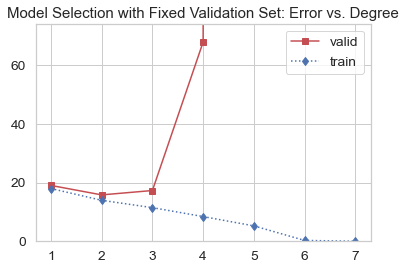

In [48]:
plot_train_and_valid_error_vs_degree(degree_list, fv_err_tr_list, fv_err_va_list);
plt.title('Model Selection with Fixed Validation Set: Error vs. Degree');
plt.savefig('figure1-err_vs_degree-fv.pdf')

### Prediction 1: Score on the test set using the chosen model

In [49]:
# TODO compute score on test set for later
# The choosen model is the quadratic model, which corresponds to pipeline_list[1]
yhat_te_P = pipeline.predict(x_te_PF)
err_te = calc_mean_squared_error(y_te_P, yhat_te_P)

print(err_te)

30911680085159.254


In [51]:
def pretty_print_weights(pipeline):
    feature_names = pipeline.named_steps['poly_transformer'].get_feature_names(['horsepower', 'weight', 'cylinders', 'displacement', 'mpg'])
    for ff in range(len(feature_names)):
        coef_val_ff = pipeline.named_steps['linear_regr'].coef_[ff]
        if np.allclose(coef_val_ff, 0):
            coef_str = "   0 exactly"
        else:
            coef_str = "% 8.3f" % coef_val_ff
        print("Feature %5s: weight coef %s" % (feature_names[ff], coef_str))
            
    #print("Intercept    : weight coef % 8.3f" % (pipeline.named_steps['linear_regr'].intercept_))

In [53]:
print("Selected Parameters:")
pretty_print_weights(pipeline_list[1])
#print("TODO")
print("Fixed validation set estimate of heldout error:")
print(fv_err_va_list[1])
print("Error on the test-set:")
print(err_te)

Selected Parameters:
Feature horsepower: weight coef  -40.724
Feature weight: weight coef   -7.197
Feature cylinders: weight coef  -11.001
Feature displacement: weight coef  -11.097
Feature horsepower^2: weight coef   -4.450
Feature horsepower weight: weight coef    8.804
Feature horsepower cylinders: weight coef   26.385
Feature horsepower displacement: weight coef    8.984
Feature weight^2: weight coef  -31.769
Feature weight cylinders: weight coef   27.175
Feature weight displacement: weight coef   13.428
Feature cylinders^2: weight coef   21.765
Feature cylinders displacement: weight coef  -80.861
Feature displacement^2: weight coef   52.649
Fixed validation set estimate of heldout error:
15.793274734511762
Error on the test-set:
30911680085159.254


# Problem 2: Cross Validation for Polynomial Feature Regression

In [15]:
x_trva_LF = x_tr_MF.copy()  # TODO fix concat your train and validation set x values
y_trva_L = y_tr_M.copy()    # TODO fix concat your train and validation set y values

In [16]:
K = 10 # num folds

degree_list = [1, 2, 3, 4, 5, 6, 7]
cv_err_tr_list = []
cv_err_va_list = []

for degree in degree_list:

    # TODO create a pipeline using features with current degree value
        
    # TODO call your function to train a separate model for each fold and return train and valid errors
    # Don't forget to pass random_state = SEED (where SEED is defined above) so its reproducible
    # tr_error_K, valid_error_K = train_models_and_calc_scores_for_n_fold_cv() # TODO
    
    err_tr = 20.0 # TODO fixme, compute average error across all train folds
    err_va = 25.0 # TODO fixme, compute average error across all heldout folds
    
    cv_err_tr_list.append(err_tr)
    cv_err_va_list.append(err_va)

### Figure 2: Error vs degree

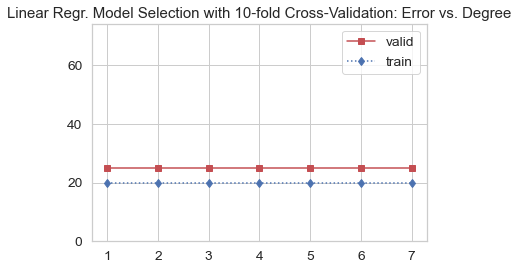

In [17]:
plot_train_and_valid_error_vs_degree(degree_list, cv_err_tr_list, cv_err_va_list)
plt.title('Linear Regr. Model Selection with 10-fold Cross-Validation: Error vs. Degree');
plt.savefig('figure2-err_vs_degree-cv-seed=%d.pdf' % SEED)

### Prediction 2: Score on the test set using the chosen model

Use the chosen hyperparameters, retrain ONE model on the FULL train+valid set.
Then make predictions on the heldout test set.

In [18]:
# TODO compute score on test set for later

In [19]:
print("Selected Parameters:")
print("TODO")
print("10-fold CV estimate of heldout error:")
print("TODO")
print("Error on the test-set:")
print("TODO")

Selected Parameters:
TODO
10-fold CV estimate of heldout error:
TODO
Error on the test-set:
TODO


# Problem 3: Cross Validation for Ridge Regression

In [20]:
alpha_grid = np.logspace(-6, 6, 13) # 10^-6, 10^-5, 10^-4, ... 10^-1, 10^0, 10^1, ... 10^6

degree_list = [1, 2, 3, 4, 5, 6, 7]

K = 10 # num folds
ridge_cv_err_tr_list = []
ridge_cv_err_va_list = []

ridge_param_list = list()

for degree in degree_list:
    for alpha in alpha_grid:
        ridge_param_list.append(dict(alpha=alpha, degree=degree))
        # TODO create a pipeline using features with current degree value
        
        # TODO call your function to train a separate model for each fold and return train and valid errors
        # Don't forget to pass random_state = SEED (where SEED is defined above) so its reproducible
        # tr_error_K, valid_error_K = train_models_and_calc_scores_for_n_fold_cv() # TODO
    
        err_tr = 20.0 # TODO fixme, compute average error across all train folds
        err_va = 25.0 # TODO fixme, compute average error across all heldout folds
    
        ridge_cv_err_tr_list.append(err_tr)
        ridge_cv_err_va_list.append(err_va)

### Figure 3: Error vs degree at alpha = 10^-3, alpha = 1, alpha = 1000

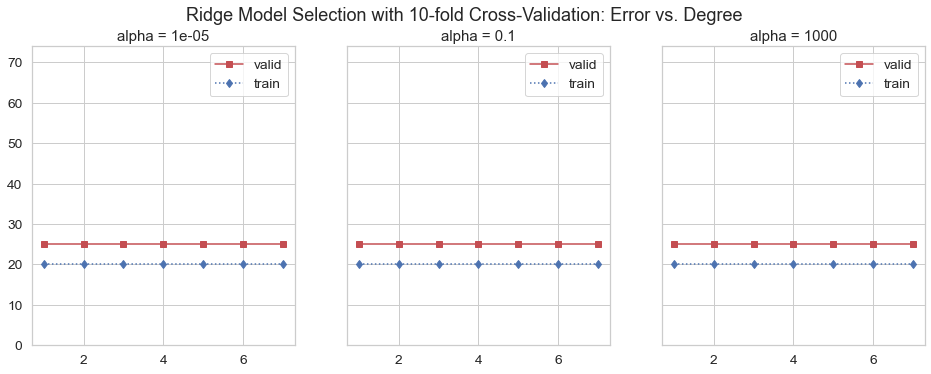

In [21]:
fig, ax_grid = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(16, 5.5))

for aa, alpha in enumerate([0.00001, 0.1, 1000.0]):
    # Find the elements of the param list that correspond to setting alpha to specific value
    match_ids = [pp for pp in range(len(ridge_param_list)) if np.allclose(alpha, ridge_param_list[pp]['alpha'])]
    train_err = np.asarray(ridge_cv_err_tr_list)[match_ids]
    test_err = np.asarray(ridge_cv_err_va_list)[match_ids]

    # Select which panel (of the 3 in figure) to be current active axis
    cur_ax = ax_grid[aa]
    plt.sca(cur_ax);
    
    # Set the title of the active axis
    cur_ax.set_title('alpha = %.5g' % alpha)

    # Draw line plot in active axis
    plot_train_and_valid_error_vs_degree(degree_list, train_err, test_err)

plt.suptitle('Ridge Model Selection with 10-fold Cross-Validation: Error vs. Degree');
plt.savefig('figure3-3_panels_by_alpha-err_vs_degree-seed=%d.pdf' % SEED, pad_inches=0, bbox_inches='tight')

### Prediction 3: Score on the test set using the chosen model


In [22]:
print("Selected Parameters (alpha and degree):")
print("TODO")
print("10-fold CV estimate of heldout error:")
print("TODO")
print("Error on the test-set:")
print("TODO")

Selected Parameters (alpha and degree):
TODO
10-fold CV estimate of heldout error:
TODO
Error on the test-set:
TODO
